In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
#import model
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import numpy as np
matplotlib.style.use('ggplot')
from torchvision.datasets import MNIST
import os
import numpy as np
matplotlib.style.use('ggplot')
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import os
import io
import math 
import cv2

from typing import *
from functools import reduce
from collections import defaultdict
from tqdm.notebook import tqdm, trange

# NN
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import STL10

from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.utils.data import DataLoader, Dataset
from torch.distributions import Distribution, Bernoulli, Normal
import torch.nn.functional as F
from torch.nn.functional import binary_cross_entropy

# other  libraries...!!!
%matplotlib inline
import argparse
from skimage.util import random_noise

import time

In [2]:
#############################
#        CLASS              #
############################


# output features for the encoder and input features for the decoder
features = 60
# define a simple linear VAE

def un_flatten(x, channels, h, w):
        return x.view(x.size(0), channels, h, w)
    
def flatten(x):
        return x.view(x.size(0), -1)

class ConvVAE(nn.Module):
    
    # 4 linear layers. MINST data set 28*28*1 image = 27648. 
    
    def __init__(self):
        
        super(ConvVAE, self).__init__()

        self.encode = nn.Sequential(
            # 1 x 28 x 28 -> 1 x 28 x 28
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            # 1 x 28 x 28 -> 28 x 28 x 28
            nn.Conv2d(1, 28, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(28),
            nn.ReLU(),
            # 28 x 28 x 28 -> 56 x 8 x 8 
            nn.Conv2d(28, 56, kernel_size=5, stride=3,padding=0),
            nn.BatchNorm2d(56),
            nn.ReLU(),
            # 56 x 8 x 8 -> 112 x 3 x 3
            nn.Conv2d(56, 112, kernel_size=5, stride=3, padding=2),
            nn.BatchNorm2d(112),
            nn.ReLU(),
            #
            # 112 x 3 x 3 -> 224 x 2 x 2
            # equivalent to 1024 x 1 x 1 when flattened
            #
            nn.Conv2d(112, 224, kernel_size=3, stride=3, padding=2),
            nn.BatchNorm2d(224),
            nn.ReLU()
        )

        # fully-connected and latent space
        self.fc1 = nn.Linear(896, 896)
        self.fc2 = nn.Linear(896, 896)
        self.fc3 = nn.Linear(896, 896)

        self.decode = nn.Sequential(
            # 224 x 2 x 2 -> 112 x 4 x 4
            nn.ConvTranspose2d(224, 112, kernel_size=3, stride=3, padding=1),
            nn.BatchNorm2d(112),
            nn.ReLU(),
            # 112 x 3 x 3 -> 56 x 9 x 9 
            nn.ConvTranspose2d(112, 56, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(56),
            nn.ReLU(),
            # 56 x 9 x 9  -> 28 x 28 x 28
            nn.ConvTranspose2d(56, 28, kernel_size=6, stride=3,padding=1),
            nn.BatchNorm2d(28),
            nn.ReLU(),
            # 28 x 28 x 28 -> 1 x 28 x 28
            nn.ConvTranspose2d(28, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            # 1 x 28 x 28 -> 1 x 28 x 28
            nn.ConvTranspose2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )



    #ENCODER
    def encoder(self, x):
        h = flatten(self.encode(x))
        z, mu, log_var = self.bottleneck(h)
        return z, mu, log_var

    def decoder(self, z):
        z = self.fc3(z)
        z = self.decode(un_flatten(z, channels=224, h=2, w=2))
        return z
    #REPARAMETERIZE
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        #Returns a new tensor with the exponential of the elements of the input tensor input
        std = torch.exp(0.5*log_var) 
        #Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    #FORWARD FUNCTION  
    def forward(self, x,high_res_image):
        self.high_res_image = high_res_image
        # encoding
         #Applies the rectified linear unit function element-wise.
        x_org = x
        z, mu, log_var = self.encoder(x)
        reconstruction = self.decoder(z)
        
        BCE, KLD, loss = self.elbo(x_org, reconstruction, mu, log_var)
        
        return reconstruction, mu, log_var , BCE, KLD, loss, z
    
    
    def bottleneck(self, h):
        mu, log_var = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var

    #LOSS FUNCTION  
    def elbo(self, x, reconstruction, mu, log_var) :
        bce_loss = binary_cross_entropy(reconstruction, self.high_res_image, reduction='sum')
        BCE = bce_loss 
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = KLD + BCE 
        
        return BCE, KLD, loss
        

In [3]:
#############################
#        BINARIZATION       #
############################
def dynamic_binarization(image: torch.Tensor) -> torch.Tensor:
  
  image = torch.bernoulli(image)
  
  return image

In [4]:
#############################
#        PARAMETERS          #
############################

batch_size = 64
lr = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def pixalate_image(image, scale_percent = 40):
  image = image.numpy()#image.permute(1, 2, 0).numpy()
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)  
  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)+1
  height = int(small_image.shape[0] * 100 / scale_percent)+1
  dim = (width, height)  
  low_res_image = cv2.resize(small_image, dim, interpolation =  cv2.INTER_AREA) 
  return low_res_image,image

In [64]:
from skimage.metrics import structural_similarity as ssim

def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    
    diff = diff.flatten('C')
    
    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)


def compare_images(target, ref):  
    return (psnr(target, ref), ssim(target, ref, multichannel =True))

In [7]:
from torchvision.datasets import STL10

class MNIST(MNIST):
  def __getitem__(self, index:int):
    img = self.data[index]

    img, target = pixalate_image(img)

    if self.transform is not None:
        img = self.transform(img)
        

    if self.transform is not None:
        target = self.transform(target)
        

    return img, target

In [8]:
# transforms for training data
train_transform = transforms.Compose([
    transforms.ToTensor()
    
    #transforms.RandomHorizontalFlip(p=0.25),
    #transforms.RandomPerspective(p=0.25),
    #transforms.ColorJitter(),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    ])

# transforms for test data
test_transform = transforms.Compose([
    transforms.ToTensor()
])

# transforms for original image
target_transform = transforms.Compose([
                                transforms.ToTensor()
                               
                            ])


# train and validation data
train_data = MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=target_transform
)


val_data = MNIST(
    root='../input/data',
    train=False,
    download=True,
    transform=target_transform
)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../input/data/MNIST/raw/train-images-idx3-ubyte.gz to ../input/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../input/data/MNIST/raw/train-labels-idx1-ubyte.gz to ../input/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../input/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../input/data/MNIST/raw



In [9]:
# Split data into validation and test
test_data = torch.utils.data.Subset(val_data, range(int(np.floor(len(val_data)*0.4)), len(val_data)))
val_data = torch.utils.data.Subset(val_data, range(int(np.floor(len(val_data)*0.4))))

In [10]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)



val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

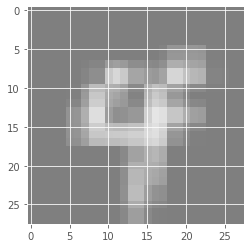

In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[1]))


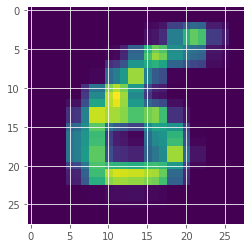

In [12]:

#choose witch image you want to see from 60000
single_image = 1

#take the labels for each train image 


with torch.no_grad():
    
    # Retrieve item
    dataiter = iter(train_loader)
    images, labels = next(dataiter)

    #data = data.to(device)
    x = images[1].size()
    # Reshape image
    plt.imshow(images[1].view(28,28))

white_torch = images[1]

torchvision.transforms.ToPILImage()(white_torch)

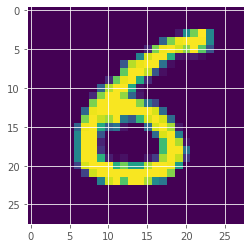

In [13]:
plt.imshow(labels[1].view(28,28))

In [14]:
dataiter = iter(train_loader)
low, high = next(dataiter)


compare_images(high[1].view(28,28).numpy(),low[1].view(28,28).numpy())

(66.51917569556875, 0.8505191568978)

In [16]:
#############################
#     TRAINING FUNCTION     #
############################

def fit(model, dataloader):
    
    start = time.time()
    model.train()
    running_loss = 0.0
    bce_running_loss = 0.0
    kl_running_loss = 0.0
    mse_running_loss = 0.0
  
    
    
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, high_res = data
        
        data = data.to(device)
        

        high_res = high_res.to(device)
        

        optimizer.zero_grad()
        start = time.time()
        reconstruction, mu, log_var, bce, kl, loss,z = model(data,high_res)
        
        
        running_loss +=   loss.item()
        bce_running_loss += bce.item()
        kl_running_loss += kl.item()
        loss.backward()
        optimizer.step()
        end = time.time()
        #print("Time inside fit: ", end-start)
    train_loss = running_loss/len(dataloader.dataset)
    train_loss_bce = bce_running_loss/len(dataloader.dataset)
    train_loss_kl = kl_running_loss/len(dataloader.dataset)
    
    

   
    return train_loss, train_loss_bce, train_loss_kl

"""### The Validation Function"""

#############################
#     VALIDATE FUNCTION     #
############################
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    bce_running_loss = 0.0
    kl_running_loss = 0.0
    mse_running_loss = 0.0

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, high_res = data

            data = data.to(device)
            

            high_res = high_res.to(device)
            

            reconstruction, mu, log_var, bce, kl, loss,z = model(data,high_res)
            
            running_loss += loss.item()
            bce_running_loss += bce.item()
            kl_running_loss += kl.item()
            

            
    val_loss = running_loss/len(dataloader.dataset)
    val_loss_bce = bce_running_loss/len(dataloader.dataset)
    val_loss_kl = kl_running_loss/len(dataloader.dataset)
    


    return val_loss, val_loss_bce, val_loss_kl


In [18]:
"""#### Initializing the Model, the Optimizer and the Loss Function"""
epochs = 150
model = ConvVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [19]:
#############################
#            RUN            #
############################

train_loss = []
train_loss_bce = []
train_loss_kl = []
train_loss_mse = []

val_loss = []
val_loss_bce = []
val_loss_kl = []
val_loss_mse = []

start = time.time()

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    
    train_epoch_loss, train_epoch_loss_bce, train_epoch_loss_kl= fit(model, train_loader)    
    end = time.time()
    
    val_epoch_loss, val_epoch_loss_bce, val_epoch_loss_kl = validate(model, test_loader)

    
    print(end-start)
    train_loss.append(train_epoch_loss)
    train_loss_bce.append(train_epoch_loss_bce)
    train_loss_kl.append(train_epoch_loss_kl)
    
    
    val_loss.append(val_epoch_loss)
    val_loss_bce.append(val_epoch_loss_bce)
    val_loss_kl.append(val_epoch_loss_kl) 
      
    
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")





Epoch 1 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

23.37430477142334
Train Loss: 352.9240
Val Loss: 258.6813
Epoch 2 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

40.65916585922241
Train Loss: 226.1087
Val Loss: 196.4363
Epoch 3 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

59.07063341140747
Train Loss: 181.4380
Val Loss: 166.6001
Epoch 4 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

76.7076952457428
Train Loss: 160.1239
Val Loss: 152.1381
Epoch 5 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

94.91888165473938
Train Loss: 146.8958
Val Loss: 140.0180
Epoch 6 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

112.48419070243835
Train Loss: 137.1272
Val Loss: 132.0624
Epoch 7 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

129.7048180103302
Train Loss: 130.2910
Val Loss: 127.1351
Epoch 8 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

147.13463425636292
Train Loss: 125.8672
Val Loss: 122.7932
Epoch 9 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

164.66844749450684
Train Loss: 121.9368
Val Loss: 119.0074
Epoch 10 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

182.12380075454712
Train Loss: 118.0040
Val Loss: 115.0609
Epoch 11 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

199.7261197566986
Train Loss: 113.9100
Val Loss: 110.7594
Epoch 12 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

217.27595496177673
Train Loss: 109.9066
Val Loss: 107.6690
Epoch 13 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

234.76824021339417
Train Loss: 107.4161
Val Loss: 105.7508
Epoch 14 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

253.07879328727722
Train Loss: 105.8845
Val Loss: 105.4353
Epoch 15 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

270.81737875938416
Train Loss: 104.7384
Val Loss: 103.9925
Epoch 16 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

288.4168691635132
Train Loss: 103.9067
Val Loss: 102.4801
Epoch 17 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

305.7803809642792
Train Loss: 103.1668
Val Loss: 102.0458
Epoch 18 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

323.18414330482483
Train Loss: 102.4124
Val Loss: 101.6177
Epoch 19 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

340.4728035926819
Train Loss: 101.5794
Val Loss: 100.6870
Epoch 20 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

357.805139541626
Train Loss: 101.1414
Val Loss: 101.9055
Epoch 21 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

375.07590770721436
Train Loss: 100.6012
Val Loss: 100.4028
Epoch 22 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

392.55597281455994
Train Loss: 100.0601
Val Loss: 99.1442
Epoch 23 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

409.9572319984436
Train Loss: 99.6742
Val Loss: 99.4386
Epoch 24 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

428.4249427318573
Train Loss: 99.2509
Val Loss: 98.7948
Epoch 25 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

445.8574068546295
Train Loss: 98.8533
Val Loss: 98.9612
Epoch 26 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

463.25587916374207
Train Loss: 98.5891
Val Loss: 97.7620
Epoch 27 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

480.69519090652466
Train Loss: 98.2659
Val Loss: 97.6958
Epoch 28 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

498.15714859962463
Train Loss: 98.0475
Val Loss: 97.7393
Epoch 29 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

515.6873841285706
Train Loss: 97.7783
Val Loss: 97.6603
Epoch 30 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

533.0589215755463
Train Loss: 97.5566
Val Loss: 97.3352
Epoch 31 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

550.4683094024658
Train Loss: 97.3406
Val Loss: 98.4211
Epoch 32 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

567.8047935962677
Train Loss: 97.1460
Val Loss: 97.0361
Epoch 33 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

585.282374382019
Train Loss: 96.9937
Val Loss: 96.9595
Epoch 34 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

603.4045329093933
Train Loss: 96.8601
Val Loss: 96.6241
Epoch 35 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

620.7340798377991
Train Loss: 96.6668
Val Loss: 96.7451
Epoch 36 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

638.1574022769928
Train Loss: 96.5409
Val Loss: 96.8046
Epoch 37 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

655.6921331882477
Train Loss: 96.3518
Val Loss: 96.8281
Epoch 38 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

673.358918428421
Train Loss: 96.2625
Val Loss: 96.1646
Epoch 39 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

691.1654744148254
Train Loss: 96.1099
Val Loss: 96.6976
Epoch 40 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

708.8181464672089
Train Loss: 96.0141
Val Loss: 96.9289
Epoch 41 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

726.4760863780975
Train Loss: 95.9083
Val Loss: 96.5019
Epoch 42 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

744.455783367157
Train Loss: 95.8094
Val Loss: 95.7356
Epoch 43 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

762.5537574291229
Train Loss: 95.6497
Val Loss: 95.9438
Epoch 44 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

781.1508703231812
Train Loss: 95.6240
Val Loss: 96.1877
Epoch 45 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

798.9104495048523
Train Loss: 95.5405
Val Loss: 95.7560
Epoch 46 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

816.7728703022003
Train Loss: 95.3619
Val Loss: 95.9084
Epoch 47 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

834.6393103599548
Train Loss: 95.3442
Val Loss: 95.4330
Epoch 48 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

852.6723163127899
Train Loss: 95.1910
Val Loss: 95.5084
Epoch 49 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

870.6604619026184
Train Loss: 95.1612
Val Loss: 95.2746
Epoch 50 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

888.2769801616669
Train Loss: 95.1197
Val Loss: 95.4472
Epoch 51 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

905.8067541122437
Train Loss: 94.9857
Val Loss: 95.4788
Epoch 52 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

923.6051862239838
Train Loss: 94.9572
Val Loss: 95.1131
Epoch 53 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

942.2184972763062
Train Loss: 94.8707
Val Loss: 95.2687
Epoch 54 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

959.9404797554016
Train Loss: 94.7406
Val Loss: 95.4304
Epoch 55 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

977.5988645553589
Train Loss: 94.7511
Val Loss: 95.7964
Epoch 56 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

995.2683928012848
Train Loss: 94.6770
Val Loss: 95.2288
Epoch 57 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1013.0488307476044
Train Loss: 94.6231
Val Loss: 95.0842
Epoch 58 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1030.9069674015045
Train Loss: 94.5657
Val Loss: 95.1822
Epoch 59 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1048.8809263706207
Train Loss: 94.4740
Val Loss: 95.0350
Epoch 60 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1066.4204466342926
Train Loss: 94.4063
Val Loss: 94.8873
Epoch 61 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1084.2678697109222
Train Loss: 94.3671
Val Loss: 94.8354
Epoch 62 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1102.1779701709747
Train Loss: 94.2733
Val Loss: 95.3123
Epoch 63 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1120.9608852863312
Train Loss: 94.2605
Val Loss: 95.0127
Epoch 64 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1138.8378992080688
Train Loss: 94.2565
Val Loss: 94.7825
Epoch 65 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1156.5820796489716
Train Loss: 94.1421
Val Loss: 94.7266
Epoch 66 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1174.50239777565
Train Loss: 94.1077
Val Loss: 94.4727
Epoch 67 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1192.4308626651764
Train Loss: 94.1053
Val Loss: 94.6837
Epoch 68 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1210.3031721115112
Train Loss: 94.0345
Val Loss: 95.1886
Epoch 69 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1228.1952562332153
Train Loss: 93.9496
Val Loss: 94.7302
Epoch 70 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1246.142802476883
Train Loss: 93.9227
Val Loss: 94.5276
Epoch 71 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1264.1579263210297
Train Loss: 93.8423
Val Loss: 94.4847
Epoch 72 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1281.8329937458038
Train Loss: 93.9085
Val Loss: 94.3822
Epoch 73 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1300.6359775066376
Train Loss: 93.7982
Val Loss: 96.2854
Epoch 74 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1318.4376192092896
Train Loss: 93.7070
Val Loss: 94.5543
Epoch 75 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1336.294941186905
Train Loss: 93.7136
Val Loss: 94.7764
Epoch 76 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1354.913865327835
Train Loss: 93.7004
Val Loss: 94.6415
Epoch 77 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1372.6275491714478
Train Loss: 93.6333
Val Loss: 94.2236
Epoch 78 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1390.3317692279816
Train Loss: 93.5978
Val Loss: 94.6408
Epoch 79 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1408.4014670848846
Train Loss: 93.5077
Val Loss: 94.5358
Epoch 80 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1426.4094588756561
Train Loss: 93.5515
Val Loss: 94.6575
Epoch 81 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1444.3959875106812
Train Loss: 93.5448
Val Loss: 94.2593
Epoch 82 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1462.9818789958954
Train Loss: 93.4471
Val Loss: 94.3100
Epoch 83 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1481.030639410019
Train Loss: 93.4213
Val Loss: 94.6329
Epoch 84 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1499.158107995987
Train Loss: 93.4073
Val Loss: 94.4372
Epoch 85 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1517.8963692188263
Train Loss: 93.3151
Val Loss: 94.0279
Epoch 86 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1536.3382024765015
Train Loss: 93.3053
Val Loss: 94.7947
Epoch 87 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1554.3786442279816
Train Loss: 93.2801
Val Loss: 94.3458
Epoch 88 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1572.3881843090057
Train Loss: 93.2554
Val Loss: 94.1727
Epoch 89 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1590.4133067131042
Train Loss: 93.2049
Val Loss: 94.1912
Epoch 90 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1608.3769042491913
Train Loss: 93.2204
Val Loss: 94.1870
Epoch 91 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1626.7618494033813
Train Loss: 93.1804
Val Loss: 94.2934
Epoch 92 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1646.4797899723053
Train Loss: 93.1346
Val Loss: 94.0704
Epoch 93 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1665.5435984134674
Train Loss: 93.1115
Val Loss: 93.9946
Epoch 94 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1684.2992057800293
Train Loss: 93.0489
Val Loss: 94.1711
Epoch 95 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1702.7551081180573
Train Loss: 93.0654
Val Loss: 93.8828
Epoch 96 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1721.1421866416931
Train Loss: 93.0340
Val Loss: 94.1745
Epoch 97 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1739.4266080856323
Train Loss: 93.0128
Val Loss: 93.9705
Epoch 98 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1757.677829027176
Train Loss: 92.9848
Val Loss: 94.3576
Epoch 99 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1776.0089435577393
Train Loss: 92.9362
Val Loss: 94.1357
Epoch 100 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1794.2554168701172
Train Loss: 92.9259
Val Loss: 94.1807
Epoch 101 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1812.3947417736053
Train Loss: 92.8685
Val Loss: 93.7654
Epoch 102 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1831.1670112609863
Train Loss: 92.8242
Val Loss: 94.1978
Epoch 103 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1849.0977239608765
Train Loss: 92.8720
Val Loss: 94.0722
Epoch 104 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1866.9601798057556
Train Loss: 92.8300
Val Loss: 93.8449
Epoch 105 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1884.8544266223907
Train Loss: 92.7580
Val Loss: 93.7369
Epoch 106 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1902.97150015831
Train Loss: 92.7669
Val Loss: 94.0370
Epoch 107 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1921.014729976654
Train Loss: 92.7486
Val Loss: 93.9908
Epoch 108 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1938.9504282474518
Train Loss: 92.7199
Val Loss: 94.1291
Epoch 109 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1957.140435218811
Train Loss: 92.7078
Val Loss: 93.9889
Epoch 110 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1975.2368924617767
Train Loss: 92.7119
Val Loss: 93.8301
Epoch 111 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

1994.2424874305725
Train Loss: 92.6385
Val Loss: 93.9671
Epoch 112 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2012.4112164974213
Train Loss: 92.6190
Val Loss: 93.8366
Epoch 113 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2030.4399812221527
Train Loss: 92.5549
Val Loss: 93.8036
Epoch 114 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2048.4628698825836
Train Loss: 92.6207
Val Loss: 93.8335
Epoch 115 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2066.2875344753265
Train Loss: 92.5534
Val Loss: 94.1971
Epoch 116 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2084.151551246643
Train Loss: 92.5458
Val Loss: 93.7192
Epoch 117 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2101.94016122818
Train Loss: 92.5161
Val Loss: 94.1646
Epoch 118 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2119.84685254097
Train Loss: 92.4912
Val Loss: 94.1505
Epoch 119 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2137.6778218746185
Train Loss: 92.4502
Val Loss: 93.8325
Epoch 120 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2155.432080745697
Train Loss: 92.4444
Val Loss: 93.7554
Epoch 121 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2174.0078620910645
Train Loss: 92.4568
Val Loss: 93.7843
Epoch 122 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2191.889901161194
Train Loss: 92.4353
Val Loss: 93.4661
Epoch 123 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2209.9232745170593
Train Loss: 92.3695
Val Loss: 93.7037
Epoch 124 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2227.732853412628
Train Loss: 92.3782
Val Loss: 93.6091
Epoch 125 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2245.572036743164
Train Loss: 92.3737
Val Loss: 94.0491
Epoch 126 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2263.412926673889
Train Loss: 92.3347
Val Loss: 93.6066
Epoch 127 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2281.456990003586
Train Loss: 92.2957
Val Loss: 93.8009
Epoch 128 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2299.7611498832703
Train Loss: 92.2796
Val Loss: 93.4709
Epoch 129 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2317.654667854309
Train Loss: 92.2868
Val Loss: 93.6051
Epoch 130 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2335.530715227127
Train Loss: 92.2228
Val Loss: 93.5565
Epoch 131 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2354.4224395751953
Train Loss: 92.2531
Val Loss: 93.5723
Epoch 132 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2372.554660797119
Train Loss: 92.1956
Val Loss: 93.6257
Epoch 133 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2390.5393092632294
Train Loss: 92.2263
Val Loss: 93.4852
Epoch 134 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2408.421194076538
Train Loss: 92.1961
Val Loss: 93.6477
Epoch 135 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2426.1865890026093
Train Loss: 92.1429
Val Loss: 93.4576
Epoch 136 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2444.1790356636047
Train Loss: 92.1304
Val Loss: 93.7015
Epoch 137 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2462.1538803577423
Train Loss: 92.1421
Val Loss: 93.7393
Epoch 138 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2480.2108991146088
Train Loss: 92.1464
Val Loss: 93.6252
Epoch 139 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2498.213565826416
Train Loss: 92.0766
Val Loss: 93.6292
Epoch 140 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2516.289050102234
Train Loss: 92.0524
Val Loss: 93.6680
Epoch 141 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2535.279712200165
Train Loss: 92.0816
Val Loss: 93.7915
Epoch 142 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2553.055743932724
Train Loss: 92.0433
Val Loss: 93.6340
Epoch 143 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2571.2143936157227
Train Loss: 92.0598
Val Loss: 93.7111
Epoch 144 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2589.1890001296997
Train Loss: 92.0178
Val Loss: 93.6187
Epoch 145 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2607.39862203598
Train Loss: 92.0235
Val Loss: 93.3413
Epoch 146 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2625.5533390045166
Train Loss: 91.9970
Val Loss: 93.5865
Epoch 147 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2643.89031124115
Train Loss: 91.9880
Val Loss: 93.4044
Epoch 148 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2662.1722526550293
Train Loss: 91.9878
Val Loss: 93.5777
Epoch 149 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2680.2251975536346
Train Loss: 91.9187
Val Loss: 93.2989
Epoch 150 of 150


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

2698.4136373996735
Train Loss: 91.9361
Val Loss: 93.6409


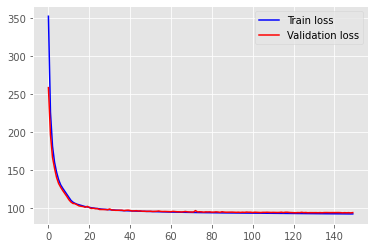

In [20]:
plt.plot(list(range(0,epochs)), train_loss, color='blue', label='Train loss')
plt.plot(list(range(0,epochs)), val_loss, color = 'red', label='Validation loss')
plt.legend()

In [21]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T
from torchvision.io import read_image

with torch.no_grad():
    
    # Retrieve item
    dataiter = iter(test_loader)
    input, target = next(dataiter)
    print(input.size())
    data = input[1].to(device)
    
    labels = target[1].to(device)
    print(labels.unsqueeze(1).size())

    reconstruction, mu, log_var, bce, kl, loss ,z = model(data.unsqueeze(1),labels.unsqueeze(1))
   

torch.Size([64, 1, 28, 28])
torch.Size([1, 1, 28, 28])


In [22]:
input_img = input[1]
target_img = target[1]
out_img = reconstruction.cpu()
out_img = out_img.view(data.size(0), -1)
out_img = out_img.reshape(1,28,28)

In [28]:
compare_images(input_img.permute(1, 2, 0).numpy(),target_img.permute(1, 2, 0).numpy())

(63.59697126570752, 0.6471596667987874)

In [29]:
compare_images(out_img.permute(1, 2, 0).numpy(),target_img.permute(1, 2, 0).numpy())

(67.31232275021353, 0.8600319609722505)

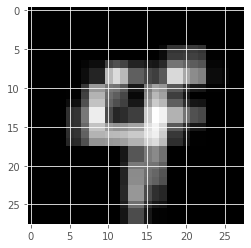

In [30]:
plt.imshow(input_img.view(28,28).cpu().detach().numpy(), cmap='gray', interpolation='none')

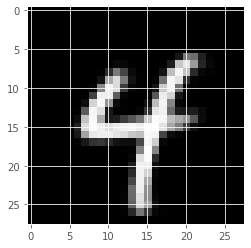

In [31]:
plt.imshow(out_img.view(28,28).cpu().detach().numpy(), cmap='gray', interpolation='none')

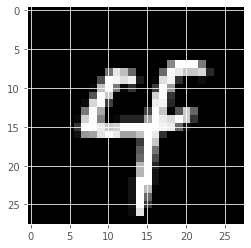

In [32]:
plt.imshow(target_img.view(28,28).cpu().detach().numpy(), cmap='gray', interpolation='none')

#### Test and Save

In [40]:
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1,
                                          shuffle=False, num_workers=2)

In [52]:
#############################
#     TEST FUNCTION     #
############################
def test(model, dataloader):
    mse_loss = nn.functional.mse_loss
    model.eval()
    running_loss = 0.0
    mse_running_loss = 0.0
    psnr_running_loss = 0.0
    ssim_running_loss = 0.0

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, high_res = data

            data = data.to(device)
            

            high_res = high_res.to(device)
            

            reconstruction, _, _, _, _, loss, _ = model(data,high_res)

            psnr, ssim = compare_images(high_res.view((high_res.size(2), high_res.size(3), high_res.size(1))).cpu().numpy(), reconstruction.view((reconstruction.size(2), reconstruction.size(3), reconstruction.size(1))).cpu().numpy())
            
            running_loss += loss.item()
            psnr_running_loss += psnr
            ssim_running_loss += ssim
            mse_running_loss += mse_loss(reconstruction, high_res)          
            
            
    test_loss = running_loss/len(dataloader.dataset)
    psnr = psnr_running_loss/len(dataloader.dataset)
    ssim = ssim_running_loss/len(dataloader.dataset)
    mse = mse_running_loss/len(dataloader.dataset)


    return test_loss, psnr, ssim, mse.cpu().item()


In [53]:
test_loss, test_psnr, test_ssim, test_mse = test(model, val_loader)

  0%|          | 0/4000 [00:00<?, ?it/s]

In [55]:
test_loss, test_psnr, test_ssim, test_mse.cpu().item()

(93.55028890895844,
 68.75750855231229,
 0.9021717456484066,
 0.009823990054428577)

In [62]:
def metrics_on_loader(dataloader):
    psnr_running_loss = 0.0
    ssim_running_loss = 0.0

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, high_res = data
            data = data.cpu()
            high_res = high_res.cpu()
            
            _psnr, _ssim = compare_images(high_res.view((high_res.size(2), high_res.size(3), high_res.size(1))).numpy(), data.view((data.size(2), data.size(3), data.size(1))).numpy())
            
            psnr_running_loss += _psnr
            ssim_running_loss += _ssim            
            
    psnr = psnr_running_loss/len(dataloader.dataset)
    ssim = ssim_running_loss/len(dataloader.dataset)

    return psnr, ssim


In [65]:
metrics_on_loader(val_loader)

  0%|          | 0/4000 [00:00<?, ?it/s]

(64.86188240406493, 0.7416098869853249)

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
torch.save(model.state_dict(), '/content/drive/MyDrive/DTU/DL/Deep_Learning/Notebooks/Output/Models/vae_conv_mnist.pth')